In [508]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
reddit_data = pd.read_excel('cleaned_reddit_india.xlsx')

### Initial classifier approach using numerical columns - both continuous and categorical

In [5]:
feature_cols = ('is_orig', 'n_comm', 'total_awards', 'up_count', 'upvote_rat', 'calc_down_count')

In [31]:
mod_flair_vc = reddit_data.mod_flair.value_counts()

### Since most flairs have very little data and creating a classifier with way too many classes would result in poor results, all flairs with less than 10 entries have been re-classsified as other

In [37]:
reddit_data['double_mod_flair'] = np.where(reddit_data['mod_flair'].isin(mod_flair_vc.index[mod_flair_vc>=10]), reddit_data['mod_flair'], 'other')

In [38]:
mod_flair_vc

Non-Political                109
Coronavirus                  108
Politics                      76
AskIndia                      31
[R]eddiquette                 10
Sports                         8
Photography                    8
Science/Technology             8
Policy/Economy                 7
r/all                          4
Business/Finance               3
Food                           3
other                          2
Scheduled                      2
CAA-NRC                        2
Unverified                     2
| Not specific to India |      1
Totally real                   1
Official Sadness Thread        1
Demonetization                 1
Zoke Tyme                      1
Name: mod_flair, dtype: int64

### This brings down the number of flairs from 15+ to 6, a more manageable value

In [39]:
reddit_data.double_mod_flair.value_counts()

Non-Political    109
Coronavirus      108
Politics          76
other             54
AskIndia          31
[R]eddiquette     10
Name: double_mod_flair, dtype: int64

In [22]:
reddit_data.mod_flair.fillna('other', inplace=True)

### Splitting the numerical data and the target using an 80/20 split

In [565]:
X_train, X_test, y_train, y_test = train_test_split(reddit_data[list(feature_cols)], reddit_data.double_mod_flair, test_size=0.2)

### Trying out a basic Random Forest Classifier on this data

In [566]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [568]:
accuracy_score(y_train, rf_clf.predict(X_train))

0.9967741935483871

In [569]:
accuracy_score(y_test, rf_clf.predict(X_test))

0.5128205128205128

### While the model has overfit on the training data, the performance on the test set isn't as good

In [50]:
y_test.value_counts().index.sort_values()

Index(['AskIndia', 'Coronavirus', 'Non-Political', 'Politics', '[R]eddiquette',
       'other'],
      dtype='object')

In [64]:
confusion_matrix(y_test, rf_clf.predict(X_test))

array([[5, 0, 0, 0, 0, 1],
       [2, 7, 2, 3, 0, 2],
       [0, 2, 9, 2, 0, 2],
       [0, 3, 2, 6, 0, 0],
       [0, 1, 1, 2, 0, 0],
       [1, 1, 4, 0, 0, 1]], dtype=int64)

In [493]:
plt.clf()

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

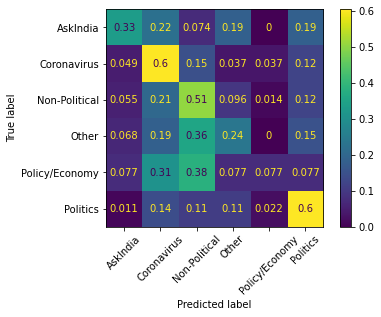

In [504]:
plt.figure(figsize=(12, 8))
plot_confusion_matrix(rf_clf, X_test, y_test, normalize='true')
plt.xticks(rotation=45)
plt.show()

### We can clearly see that the classes with the higher number of examples have a better score

### Trying out another classifier, SVM classifier with RBF kernel and default config

In [570]:
scaler = StandardScaler()
X_train_tnsf = scaler.fit_transform(X_train[[ 'n_comm', 'total_awards', 'up_count', 'upvote_rat', 'calc_down_count']])
X_test_tnsf = scaler.transform(X_test[[ 'n_comm', 'total_awards', 'up_count', 'upvote_rat', 'calc_down_count']])

In [571]:
X_train_tnsf2 = np.concatenate((X_train_tnsf, np.array(X_train[['is_orig']])), axis=1)
X_test_tnsf2 = np.concatenate((X_test_tnsf, np.array(X_test[['is_orig']])), axis=1)

In [572]:
svm_clf = svm.SVC()
svm_clf.fit(X_train_tnsf2, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [573]:
accuracy_score(y_train, svm_clf.predict(X_train_tnsf2))

0.5290322580645161

In [574]:
accuracy_score(y_test, svm_clf.predict(X_test_tnsf2))

0.41025641025641024

### As we can see, the SVM classifier isn't performing as well on this data
While the test score is quite close to the training score, it is still quite low

# Using text data as features

### While we have tried out the numerical features available, the text features are more directly related to how the flair is decided and assigned to the post. Also, the numerical columns for a post can vary quite a bit over time i.e. the number of comments, upvotes can significantly change as it is discussed more. However, the initial title and initial comments are less likely to change over time. Thus, it makes intuitive sense to try out text classifiers

#### Processing text with a basic Tfidf vectorizer followed by simple classifiers as tried above

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [108]:
text_rf_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', ensemble.RandomForestClassifier())])

In [623]:
reddit_data.clean_comments.fillna('', inplace=True)
reddit_data.clean_title.fillna('', inplace=True)
reddit_data.clean_title_text.fillna('', inplace=True)
reddit_data['all_text'] = reddit_data.clean_comments.str.cat(reddit_data['clean_title'], sep=' ')
reddit_data['all_text'] = reddit_data.all_text.str.cat(reddit_data['clean_title_text'], sep=' ')
reddit_data.all_text.fillna('', inplace=True)

In [624]:
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(reddit_data.all_text, reddit_data.mod_flair, test_size=0.2)

In [625]:
text_rf_clf.fit(text_X_train, text_y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [626]:
accuracy_score(text_y_train, text_rf_clf.predict(text_X_train))

1.0

In [627]:
accuracy_score(text_y_test, text_rf_clf.predict(text_X_test))

0.46153846153846156

### Again, we face the problem of overfitting on the training data, and not too great results on the test data

In [628]:
text_svm_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])

In [629]:
text_svm_clf.fit(text_X_train, text_y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', deg

In [630]:
accuracy_score(text_y_train, text_svm_clf.predict(text_X_train))

0.8580645161290322

In [631]:
accuracy_score(text_y_test, text_svm_clf.predict(text_X_test))

0.5384615384615384

### While this SVM model has better fit on the training data, the performance on the test set is only slightly better

## For trying out more advanced deep neural network based models, additional data is always better since deep learning models require higher amounts of data than other models

### Using additional data

In [261]:
reddit_data_v2 = pd.read_excel('cleaned_reddit_india_v2.xlsx')

In [262]:
mod_flair_v2_vc = reddit_data_v2.mod_flair.value_counts()

### Modifying flairs, classifying as other where count < 60

In [269]:
reddit_data_v2['double_mod_flair'] = np.where(reddit_data_v2['mod_flair'].isin(mod_flair_v2_vc.index[mod_flair_v2_vc>=60]), reddit_data_v2['mod_flair'], 'Other')

In [270]:
mod_flair_v2_vc

Politics                         401
Coronavirus                      401
Non-Political                    401
AskIndia                         144
Policy/Economy                    70
Business/Finance                  55
Photography                       55
Sports                            36
[R]eddiquette                     34
Science/Technology                26
Food                              19
Unverified                        16
CAA-NRC                           14
Scheduled                         12
r/all                              5
Demonetization                     2
AMA                                2
Policy & Economy                   2
Lifehacks                          1
Policy/Economy -2017 Article       1
Zoke Tyme                          1
Goal Achieved!!!                   1
Original Comics                    1
| Not specific to India |          1
Totally real                       1
Misleading                         1
Politics Source in comments        1
E

In [271]:
reddit_data_v2.double_mod_flair.value_counts()

Non-Political     401
Politics          401
Coronavirus       401
Other             303
AskIndia          144
Policy/Economy     70
Name: double_mod_flair, dtype: int64

## Before trying out NN models, we'll also try out the other models with this additional data

In [575]:
X_train, X_test, y_train, y_test = train_test_split(reddit_data_v2[list(feature_cols)], reddit_data_v2.double_mod_flair, test_size=0.2)

In [576]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [577]:
accuracy_score(y_train, rf_clf.predict(X_train))

0.9832848837209303

In [578]:
accuracy_score(y_test, rf_clf.predict(X_test))

0.4738372093023256

### The scenario didn't change much for the Random Forest Classifier

<Figure size 864x576 with 0 Axes>

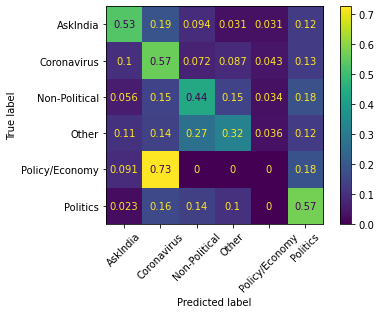

In [579]:
plt.figure(figsize=(12, 8))
plot_confusion_matrix(rf_clf, X_test, y_test, normalize='true')
plt.xticks(rotation=45)
plt.show()

## A clear observation here is that most policy columns are getting classified as Coronavirus which is an issue

In [581]:
scaler = StandardScaler()
X_train_tnsf = scaler.fit_transform(X_train[[ 'n_comm', 'total_awards', 'up_count', 'upvote_rat', 'calc_down_count']])
X_test_tnsf = scaler.transform(X_test[[ 'n_comm', 'total_awards', 'up_count', 'upvote_rat', 'calc_down_count']])

In [582]:
X_train_tnsf2 = np.concatenate((X_train_tnsf, np.array(X_train[['is_orig']])), axis=1)
X_test_tnsf2 = np.concatenate((X_test_tnsf, np.array(X_test[['is_orig']])), axis=1)

In [583]:
svm_clf = svm.SVC()
svm_clf.fit(X_train_tnsf2, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [586]:
accuracy_score(y_train, svm_clf.predict(X_train_tnsf2))

0.4789244186046512

In [587]:
accuracy_score(y_test, svm_clf.predict(X_test_tnsf2))

0.40988372093023256

## The situation with SVM didn't change much either

In [592]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [593]:
accuracy_score(y_train, xgb_clf.predict(X_train))

0.9578488372093024

In [594]:
accuracy_score(y_test, xgb_clf.predict(X_test))

0.49709302325581395

### Even XGBoost models don't seem to be improving things by a lot

In [287]:
text_rf_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', ensemble.RandomForestClassifier())])

In [632]:
reddit_data_v2.clean_comments.fillna('', inplace=True)
reddit_data_v2.clean_title.fillna('', inplace=True)
reddit_data_v2.clean_title_text.fillna('', inplace=True)
reddit_data_v2['all_text'] = reddit_data_v2.clean_comments.str.cat(reddit_data_v2['clean_title'], sep=' ')
reddit_data_v2['all_text'] = reddit_data_v2.all_text.str.cat(reddit_data_v2['clean_title_text'], sep=' ')
reddit_data_v2.all_text.fillna('', inplace=True)

In [633]:
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(reddit_data_v2.all_text, reddit_data_v2.double_mod_flair, test_size=0.2)

In [634]:
text_X_train

1614    link selfpost eli5 post nnnnadding sources dat...
931     jugaad way forward indiannyesnnwhere ppesnnwe ...
250     bsp bjd aap ysr congress support centres resol...
47      similar situation im student found hack recent...
91      women use clean peeing ppl use dry washing 1 u...
                              ...                        
1675    relevant bit interviewnn chaliye camera man ko...
1108     goi contact citizens mobile number 1921 condu...
298     civilization v intensifies homelander whats co...
1476    layer 2 tweet reddit incorrect representation ...
1626    symmetry great example fractal architecture ol...
Name: all_text, Length: 1376, dtype: object

In [635]:
text_rf_clf.fit(text_X_train, text_y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [636]:
accuracy_score(text_y_train, text_rf_clf.predict(text_X_train))

1.0

In [637]:
accuracy_score(text_y_test, text_rf_clf.predict(text_X_test))

0.5348837209302325

### Clearly the text models seem to be performing better on the test data.

## Trying out a couple of keras RNN models
### To start with, a bidirectional LSTM

In [455]:
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [693]:
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(reddit_data_v2.all_text, reddit_data_v2.double_mod_flair, test_size=0.2)

In [694]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(reddit_data_v2.all_text)
text_X_train_seq = tokenizer.texts_to_sequences(text_X_train)
text_X_test_seq = tokenizer.texts_to_sequences(text_X_test)

In [695]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [696]:
encoder = LabelEncoder()
encoder.fit(text_y_train)
text_y_train_enc = encoder.transform(text_y_train)
text_y_test_enc = encoder.transform(text_y_test)


In [697]:
np.save('model_classes.npy', encoder.classes_)

In [698]:
maxlen=70

tf_text_X_train = sequence.pad_sequences(text_X_train_seq, maxlen=maxlen)
tf_text_X_test = sequence.pad_sequences(text_X_test_seq, maxlen=maxlen)

In [699]:
len(tokenizer.word_index)

24547

### The model is getting created here with the following layers
1. Embedding layer which uses the default embeddings provided by Keras (to convert text into word embeddings)
2. A bidirectional LSTM layer to learn the patterns in the sequence of words
3. A final output layer to predict the flair

In [722]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(6, activation='sigmoid'))

#### The optimizer used is Adam, the loss monitored is categorical cross entropy for multi class classification and the metric calculated for training and test set is accuracy

In [723]:
adam = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'],)

In [724]:
from tensorflow.keras.utils import to_categorical

In [725]:
model.fit(tf_text_X_train, to_categorical(text_y_train_enc),
          batch_size=32,
          epochs=25,
          validation_data=(tf_text_X_test, to_categorical(text_y_test_enc)),)

Train on 1376 samples, validate on 344 samples
Epoch 1/25
1376/1376 [==============================] - 10s 7ms/sample - loss: 1.7047 - accuracy: 0.2362 - val_loss: 1.6320 - val_accuracy: 0.2122
Epoch 2/25
1376/1376 [==============================] - 7s 5ms/sample - loss: 1.5978 - accuracy: 0.3198 - val_loss: 1.6114 - val_accuracy: 0.2645
Epoch 3/25
1376/1376 [==============================] - 7s 5ms/sample - loss: 1.4644 - accuracy: 0.4062 - val_loss: 1.5689 - val_accuracy: 0.3285
Epoch 4/25
1376/1376 [==============================] - 8s 6ms/sample - loss: 1.1379 - accuracy: 0.6076 - val_loss: 1.6870 - val_accuracy: 0.3576
Epoch 5/25
1376/1376 [==============================] - 7s 5ms/sample - loss: 0.9551 - accuracy: 0.6483 - val_loss: 1.7392 - val_accuracy: 0.4215
Epoch 6/25
1376/1376 [==============================] - 8s 5ms/sample - loss: 0.7041 - accuracy: 0.7849 - val_loss: 1.7661 - val_accuracy: 0.3983
Epoch 7/25
1376/1376 [==============================] - 8s 6ms/sample - loss

## As we can see, while the model performs quite similar to the Random Forest model where it overfits on the training set and has close scores on the test set. This can be improved by trying out other embedding models, controlling other hyperparameters like the learning rate and changing model shape to incorporate longer sequences

In [219]:
import codecs, tqdm

## The fasttext trained word embeddings trained on the Wikipedia 2017, UMBC webbase corpus have been used below
### Link to file - https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [671]:
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

In [672]:
embeddings_index={}

In [673]:
for line in tqdm.tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(f'found {len(embeddings_index)} word vectors')

999995it [03:17, 5057.05it/s]

found 999995 word vectors


In [674]:
word_index = tokenizer.word_index

In [709]:
words_not_found = []
nb_words = min(100000, len(word_index))
embedding_matrix = np.zeros((nb_words+1, 300))

## Getting the word vectors for the words in our text

In [710]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        t_shape = embedding_vector.shape
    else:
        words_not_found.append(word)
        embedding_matrix[i] = np.zeros(t_shape)
        #print(word, i, t_shape)



## Creating another model

In [711]:
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(6, activation='sigmoid'))

In [712]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, None, 300)         7364400   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 300)               541200    
_________________________________________________________________
dense_50 (Dense)             (None, 6)                 1806      
Total params: 7,907,406
Trainable params: 543,006
Non-trainable params: 7,364,400
_________________________________________________________________


In [713]:
adam = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'],)

In [714]:
model.fit(tf_text_X_train, to_categorical(text_y_train_enc),
          batch_size=32,
          epochs=25,
          validation_data=(tf_text_X_test, to_categorical(text_y_test_enc)),)

Train on 1376 samples, validate on 344 samples
Epoch 1/25
1376/1376 [==============================] - 15s 11ms/sample - loss: 1.6812 - accuracy: 0.2674 - val_loss: 1.6147 - val_accuracy: 0.2180
Epoch 2/25
1376/1376 [==============================] - 12s 9ms/sample - loss: 1.5507 - accuracy: 0.3844 - val_loss: 1.5249 - val_accuracy: 0.4273
Epoch 3/25
1376/1376 [==============================] - 12s 9ms/sample - loss: 1.3833 - accuracy: 0.4658 - val_loss: 1.4036 - val_accuracy: 0.4302
Epoch 4/25
1376/1376 [==============================] - 12s 9ms/sample - loss: 1.3032 - accuracy: 0.4789 - val_loss: 1.2950 - val_accuracy: 0.5087
Epoch 5/25
1376/1376 [==============================] - 12s 9ms/sample - loss: 1.1788 - accuracy: 0.5443 - val_loss: 1.2330 - val_accuracy: 0.5262
Epoch 6/25
1376/1376 [==============================] - 12s 9ms/sample - loss: 1.1449 - accuracy: 0.5480 - val_loss: 1.2587 - val_accuracy: 0.5465
Epoch 7/25
1376/1376 [==============================] - 12s 9ms/sample

### As we can see with this model, the overfitting has reduced and the difference between training and validation scores as well. This model can also be re-trained as and when we gather more data

In [719]:
model.save('BLSTM_model.h5')

## Trying out one more model - [CNNs](https://keras.io/examples/imdb_cnn/) for text classification from Keras

In [727]:
model2 = Sequential()
model2.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(6, activation='sigmoid'))

In [726]:
cb = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

In [728]:
model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'],)

In [729]:
model2.fit(tf_text_X_train, to_categorical(text_y_train_enc),
          batch_size=32,
          epochs=15,
          validation_data=(tf_text_X_test, to_categorical(text_y_test_enc)),callbacks=[cb])

Train on 1376 samples, validate on 344 samples
Epoch 1/15
1376/1376 [==============================] - 4s 3ms/sample - loss: 1.6295 - accuracy: 0.3423 - val_loss: 1.5621 - val_accuracy: 0.3488
Epoch 2/15
1376/1376 [==============================] - 2s 1ms/sample - loss: 1.3953 - accuracy: 0.5305 - val_loss: 1.4522 - val_accuracy: 0.4331
Epoch 3/15
1376/1376 [==============================] - 2s 1ms/sample - loss: 1.1677 - accuracy: 0.6483 - val_loss: 1.3870 - val_accuracy: 0.4419
Epoch 4/15
1376/1376 [==============================] - 2s 1ms/sample - loss: 0.9829 - accuracy: 0.7442 - val_loss: 1.3502 - val_accuracy: 0.4564
Epoch 5/15
1376/1376 [==============================] - 2s 1ms/sample - loss: 0.8329 - accuracy: 0.8060 - val_loss: 1.3235 - val_accuracy: 0.4884
Epoch 6/15
1376/1376 [==============================] - 2s 1ms/sample - loss: 0.7040 - accuracy: 0.8612 - val_loss: 1.3427 - val_accuracy: 0.4651
Epoch 7/15
1376/1376 [==============================] - 2s 1ms/sample - loss:

In [718]:
model2.save('CNN_model.h5')

## The intention here was to try out another word embedding - ELMo to see if the models turned out to be better.
## However, due to some tensorflow version issues, this didn't work out. Will continue to try this out

In [428]:
import tensorflow_hub as tf_hub

In [448]:
from tensorflow.compat import v1
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [435]:
embed = tf_hub.Module('https://tfhub.dev/google/elmo/2', trainable=True,
                               name="elmo_embed")


In [436]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [449]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = tf_hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K. .tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [450]:
input_text = Input(shape=(1,), dtype="string")
embedding = ElmoEmbeddingLayer()(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[input_text], outputs=pred)

AttributeError: module 'tensorflow_core.keras.backend' has no attribute 'tf'